In [14]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from typing import TypedDict
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()

class State(TypedDict):
    value: str

def node_a(state: State): 
    print("Node A")
    return Command(
        goto="node_b", 
        update={
            "value": state["value"] + "a"
        }
    )

def node_b(state: State): 
    print("Node B")

    human_response = interrupt("Do you want to go to C or D? Type C/D")

    print("Human Review Values: ", human_response)
    
    if(human_response == "C"): 
        return Command(
            goto="node_c", 
            update={
                "value": state["value"] + "b"
            }
        ) 
    elif(human_response == "D"): 
        return Command(
            goto="node_d", 
            update={
                "value": state["value"] + "b"
            }
        )


def node_c(state: State): 
    print("Node C")
    return Command(
        goto=END, 
        update={
            "value": state["value"] + "c"
        }
    )

def node_d(state: State): 
    print("Node D")
    return Command(
        goto=END, 
        update={
            "value": state["value"] + "d"
        }
)

graph = StateGraph(State)

graph.add_node("node_a", node_a)
graph.add_node("node_b", node_b)
graph.add_node("node_c", node_c)
graph.add_node("node_d", node_d)

graph.set_entry_point("node_a") 

app = graph.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}

initialState = {
    "value": ""
}

first_result = app.invoke(initialState, config, stream_mode="updates")
first_result



Node A
Node B


[{'node_a': {'value': 'a'}},
 {'__interrupt__': (Interrupt(value='Do you want to go to C or D? Type C/D', resumable=True, ns=['node_b:cd99ac8a-8fce-e98f-95d4-d8ade05b5a14']),)}]

In [15]:

print(app.get_state(config).next)

('node_b',)


In [16]:
second_result = app.invoke(Command(resume="C"), config=config, stream_mode="updates")
second_result

Node B
Human Review Values:  C
Node C


[{'node_b': {'value': 'ab'}}, {'node_c': {'value': 'abc'}}]

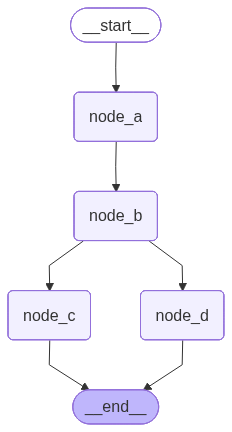

In [17]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from typing import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

memory = MemorySaver()

class State(TypedDict):
    value: str

def node_a(state: State):
    print("Node A")
    return Command(
        goto="node_b",
        update={"value": state["value"] + "a"}
    )

def node_b(state: State):
    print("Node B")

    human_response = interrupt("Do you want to go to C or D? Type C/D")
    print("Human Review Values:", human_response)

    if human_response == "C":
        return Command(
            goto="node_c",
            update={"value": state["value"] + "b"}
        )
    elif human_response == "D":
        return Command(
            goto="node_d",
            update={"value": state["value"] + "b"}
        )

def node_c(state: State):
    print("Node C")
    return Command(
        goto=END,
        update={"value": state["value"] + "c"}
    )

def node_d(state: State):
    print("Node D")
    return Command(
        goto=END,
        update={"value": state["value"] + "d"}
    )

# Build the graph
graph = StateGraph(State)

graph.add_node("node_a", node_a)
graph.add_node("node_b", node_b)
graph.add_node("node_c", node_c)
graph.add_node("node_d", node_d)

# Explicitly set entry point
graph.add_edge(START, "node_a")

# Explicitly define edges so they show in the diagram
graph.add_edge("node_a", "node_b")
graph.add_edge("node_b", "node_c")
graph.add_edge("node_b", "node_d")
graph.add_edge("node_c", END)
graph.add_edge("node_d", END)

# Compile app
app = graph.compile(checkpointer=memory)

# Display correct graph
display(Image(app.get_graph().draw_mermaid_png()))


In [18]:
config = {"configurable": {"thread_id": "1"}}

initialState = {
    "value": ""
}

first_result = app.invoke(initialState, config, stream_mode="updates")
first_result

Node A
Node B


[{'node_a': {'value': 'a'}},
 {'__interrupt__': (Interrupt(value='Do you want to go to C or D? Type C/D', resumable=True, ns=['node_b:ea05bb82-ff11-998d-f22e-29bcf083ddee']),)}]

In [19]:
print(app.get_state(config).next)

('node_b',)


In [20]:
second_result = app.invoke(Command(resume="C"), config=config, stream_mode="updates")
second_result

Node B
Human Review Values: C
Node C
Node D


InvalidUpdateError: At key 'value': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE



---

## **Why we're Getting `InvalidUpdateError`**

LangGraph complains here:

> **"At key 'value': Can receive only one value per step."**

This means:

* In your graph, **multiple nodes are trying to update `value` in the same step**.
* After resuming from an `interrupt`, **LangGraph replays the current node (`node_b`)**, then immediately jumps to **node\_c** or **node\_d**.
* Both nodes attempt to **update the same key `value`**, which LangGraph blocks by default.

---

## **Solution: Use `Annotated` for `value`**

LangGraph has a built-in way to **allow multiple updates** on the same key within one step — using **Annotated types**.

### **Fix**

```python
from typing import Annotated

class State(TypedDict):
    value: Annotated[str, "aggregate"]
```

This tells LangGraph:

> *"It's okay if multiple nodes update `value` within a single step; just merge them sequentially."*

---

## **Updated Full Code**

```python
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from typing import TypedDict, Annotated
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

memory = MemorySaver()

# ✅ Allow multiple updates using Annotated
class State(TypedDict):
    value: Annotated[str, "aggregate"]

def node_a(state: State):
    print("Node A")
    return Command(
        goto="node_b",
        update={"value": state["value"] + "a"}
    )

def node_b(state: State):
    print("Node B")
    human_response = interrupt("Do you want to go to C or D? Type C/D")
    print("Human Review Values:", human_response)

    if human_response == "C":
        return Command(
            goto="node_c",
            update={"value": state["value"] + "b"}
        )
    elif human_response == "D":
        return Command(
            goto="node_d",
            update={"value": state["value"] + "b"}
        )

def node_c(state: State):
    print("Node C")
    return Command(
        goto=END,
        update={"value": state["value"] + "c"}
    )

def node_d(state: State):
    print("Node D")
    return Command(
        goto=END,
        update={"value": state["value"] + "d"}
    )

# Build graph
graph = StateGraph(State)
graph.add_node("node_a", node_a)
graph.add_node("node_b", node_b)
graph.add_node("node_c", node_c)
graph.add_node("node_d", node_d)

graph.add_edge(START, "node_a")
graph.add_edge("node_a", "node_b")
graph.add_edge("node_b", "node_c")
graph.add_edge("node_b", "node_d")
graph.add_edge("node_c", END)
graph.add_edge("node_d", END)

# Compile app
app = graph.compile(checkpointer=memory)

# Display graph
display(Image(app.get_graph().draw_mermaid_png()))

# Initial config
config = {"configurable": {"thread_id": "1"}}
initialState = {"value": ""}

# First invoke — pauses at node_b
first_result = app.invoke(initialState, config, stream_mode="updates")
print(first_result)

# Resume after interrupt — choose C
second_result = app.invoke(Command(resume="C"), config=config, stream_mode="updates")
print(second_result)
```

---

## **Expected Output**

```
Node B
Human Review Values: C
Node C
[{'node_b': {'value': 'ab'}}, {'node_c': {'value': 'abc'}}]
```

---

## **Why This Works**

* Using **Annotated\[str, "aggregate"]** tells LangGraph to **sequentially combine updates** to `value`.
* Without it, LangGraph thinks **two nodes are writing `value` at the same time**, which is disallowed.

---

## **Alternative Fix (If You Don't Want Annotated)**

You can **avoid double updates** by removing the `update` from **node\_b** and only updating `value` in **node\_c** or **node\_d**.
But that changes your output, so **Annotated** is the cleanest solution ✅.

---



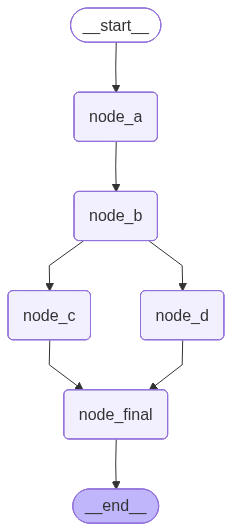

Node A
Node B
first_result chunks: [{'node_a': {'value_a': 'a'}}, {'__interrupt__': (Interrupt(value='Do you want to go to C or D? Type C/D', resumable=True, ns=['node_b:6377c898-3df6-4ee8-ef03-41dd3aefddbf']),)}]
Node B
Human Review Values: C
Node C
Node D
Node FINAL (composing branch outputs)
second_result chunks: [{'node_b': {'value_b': 'b'}}, {'node_c': {'value_branch_c': 'abc'}}, {'node_d': {'value_branch_d': 'abd'}}, {'node_final': {'value_final': 'abc'}}]


In [34]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from typing import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

memory = MemorySaver()

# separate keys so we never have two nodes writing the same key in the same step
class State(TypedDict):
    value_a: str
    value_b: str
    value_branch_c: str
    value_branch_d: str
    value_final: str

def node_a(state: State):
    print("Node A")
    return Command(
        goto="node_b",
        update={"value_a": state.get("value_a", "") + "a"}
    )

def node_b(state: State):
    print("Node B")
    human_response = interrupt("Do you want to go to C or D? Type C/D")
    print("Human Review Values:", human_response)

    # write to value_b and branch according to answer
    if human_response == "C":
        return Command(goto="node_c", update={"value_b": state.get("value_b", "") + "b"})
    elif human_response == "D":
        return Command(goto="node_d", update={"value_b": state.get("value_b", "") + "b"})
    # if none, just end gracefully (optional)
    return Command(goto=END)

def node_c(state: State):
    print("Node C")
    # write branch-specific key only
    composed = state.get("value_a", "") + state.get("value_b", "") + "c"
    return Command(
        goto="node_final",
        update={"value_branch_c": composed}
    )

def node_d(state: State):
    print("Node D")
    composed = state.get("value_a", "") + state.get("value_b", "") + "d"
    return Command(
        goto="node_final",
        update={"value_branch_d": composed}
    )

def node_final(state: State):
    print("Node FINAL (composing branch outputs)")
    # pick whichever branch key exists (only one should)
    branch_val = state.get("value_branch_c") or state.get("value_branch_d") or ""
    # now write the single final key (only this node writes it)
    return Command(
        goto=END,
        update={"value_final": branch_val}
    )

# Build graph
graph = StateGraph(State)
graph.add_node("node_a", node_a)
graph.add_node("node_b", node_b)
graph.add_node("node_c", node_c)
graph.add_node("node_d", node_d)
graph.add_node("node_final", node_final)

graph.add_edge(START, "node_a")
graph.add_edge("node_a", "node_b")
graph.add_edge("node_b", "node_c")
graph.add_edge("node_b", "node_d")
graph.add_edge("node_c", "node_final")
graph.add_edge("node_d", "node_final")
graph.add_edge("node_final", END)

# compile (no aggregation_fns required)
app = graph.compile(checkpointer=memory)

# Display graph (optional)
display(Image(app.get_graph().draw_mermaid_png()))

config = {"configurable": {"thread_id": "1"}}
initialState = {
    "value_a": "",
    "value_b": "",
    "value_branch_c": "",
    "value_branch_d": "",
    "value_final": ""
}

# First run - will interrupt at node_b
first_result = app.invoke(initialState, config, stream_mode="updates")
print("first_result chunks:", first_result)

# Resume with choice C (or "D")
second_result = app.invoke(Command(resume="C"), config=config, stream_mode="updates")
print("second_result chunks:", second_result)

# You can inspect second_result chunks to find the value_final item.
